# Prototypical Generative Model (PGM) training

This file was updated on Hypatia. The most recent commit includes those updates. Might be necessary to roll back?

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
# Don't turn on deterministic ops unless in need of pain
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["savefig.facecolor"] = "white"

from experiments.configs.inf_best import get_config as get_inf_config
from experiments.configs.gen_best import get_config as get_gen_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.utils.gen_plots import plot_gen_model_training_metrics, plot_gen_dists
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# TransformationInference Network (Prototype inference)

In [2]:
ANGLE = 180
proto_config = get_inf_config(f"aug_dsprites_v2,0")
# proto_config.steps = 2000
# proto_config.warmup_steps_pct = 0.01
# proto_config.invertibility_loss_mult = 10.
proto_config.model.squash_to_bounds = True

In [3]:
rng = random.PRNGKey(proto_config.seed)
data_rng, proto_init_rng, gen_init_rng = random.split(rng, 3)

I0000 00:00:1706395091.304757  385818 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
train_ds, val_ds, _ = get_data(proto_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

In [5]:
proto_model = TransformationInferenceNet(
    bounds=proto_config.get("augment_bounds", None),
    offset=proto_config.get("augment_offset", None),
    **proto_config.model.to_dict()
)

proto_state = create_transformation_inference_state(proto_model, proto_config, proto_init_rng, input_shape)

INFO:absl:
+--------------------------------+--------------+-----------+-----------+--------+
| Name                           | Shape        | Size      | Mean      | Std    |
+--------------------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias            | (5,)         | 5         | 0.0       | 0.0    |
| params/Dense_0/kernel          | (256, 5)     | 1,280     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/bias      | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/kernel    | (4096, 2048) | 8,388,608 | 4.76e-06  | 0.0156 |
| params/MLP_0/Dense_1/bias      | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/MLP_0/Dense_1/kernel    | (2048, 1024) | 2,097,152 | 5.56e-06  | 0.0221 |
| params/MLP_0/Dense_2/bias      | (512,)       | 512       | 0.0       | 0.0    |
| params/MLP_0/Dense_2/kernel    | (1024, 512)  | 524,288   | 3.01e-05  | 0.0312 |
| params/MLP_0/Dense_3/bias      | (256,)       | 256       | 0.0       | 0.

In [6]:
train_step, eval_step = make_transformation_inference_train_and_eval(proto_model, proto_config)

In [7]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=proto_config.to_dict(),
    mode="disabled",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [8]:
total_steps = 3_000 # proto_config.steps
proto_final_state, history, _ = ciclo.train_loop(
    proto_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * proto_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

3000/3000 [==============================] - 351s 117ms/step - invertibility_loss: 0.0763 - loss: 0.1645 - x_mse: 0.0882 - η_recon_loss: 0.6399 - invertibility_loss_test: 0.0800 - loss_test: 0.1664 - x_mse_test: 0.0864 - η_recon_loss_test: 0.6288 - label_paired_image_mse_test: 0.038900e+ - ETA: 8:28:58 - invertibility_loss: 7.6092e-04 - loss: 0.2487 - x_mse: 0.2480 - η_recon_loss: 0.6905 - invertibility_loss_test: 0.0017 - loss_test: 0.3241 - x_mse_test: 0.3224 - η_recon_loss_test: 0.6910 - label_paired_image_mse_test: 0.0000e+00 - ETA: 6:22:33 - invertibility_loss: 7.1321e-04 - loss: 0.2491 - x_mse: 0.2484 - η_recon_loss: 0.6914 - invertibility_loss_test: 0.0017 - loss_test: 0.3241 - x_mse_test: 0.3224 - η_recon_loss_test: 0.6910 - label_paired_image_mse_test: 0.0000e+0 - ETA: 5:06:43 - invertibility_loss: 6.8256e-04 - loss: 0.2486 - x_mse: 0.2480 - η_recon_loss: 0.6908 - invertibility_loss_test: 0.0017 - loss_test: 0.3241 - x_mse_test: 0.3224 - η_recon_loss_test: 0.6910 - label_paire

In [9]:
run.finish()

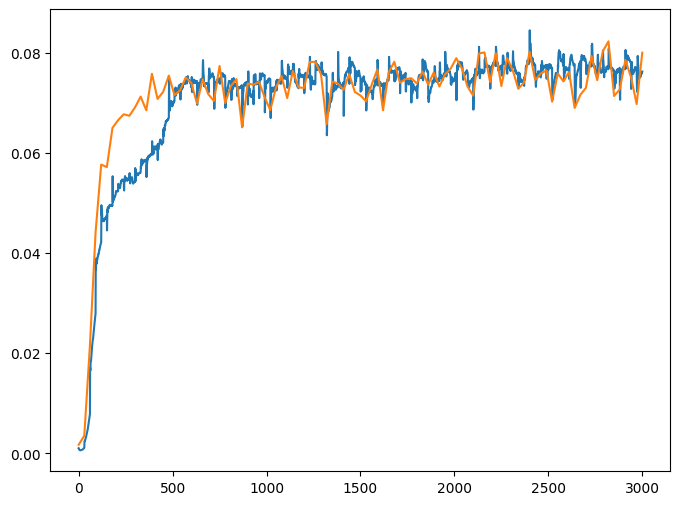

In [10]:
steps, invertibility_loss = history.collect(
        "steps",
        "invertibility_loss",
    )
steps_test, invertibility_loss_test = history.collect(
    "steps", "invertibility_loss_test"
)

# create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# plot the data
ax.plot(steps, invertibility_loss, label="train")
ax.plot(steps_test, invertibility_loss_test, label="test")


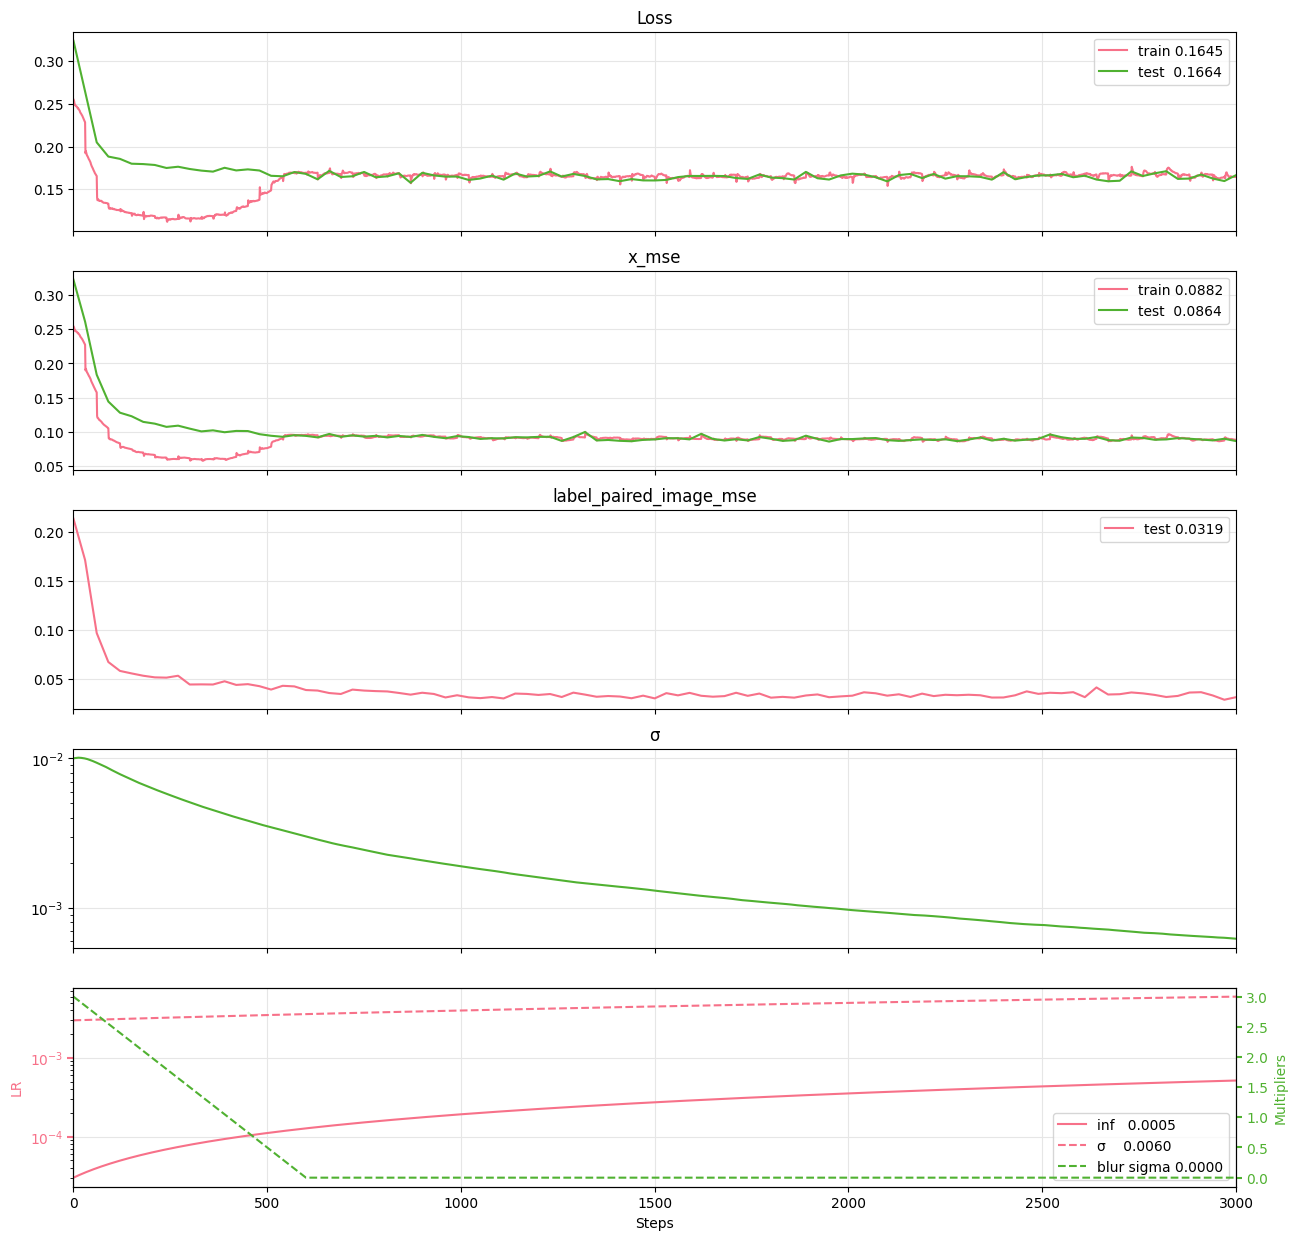

In [11]:
fig = plot_proto_model_training_metrics(history)

In [12]:
jax.nn.softplus(proto_final_state.params['σ_']).mean()

Array(0.00062067, dtype=float32)

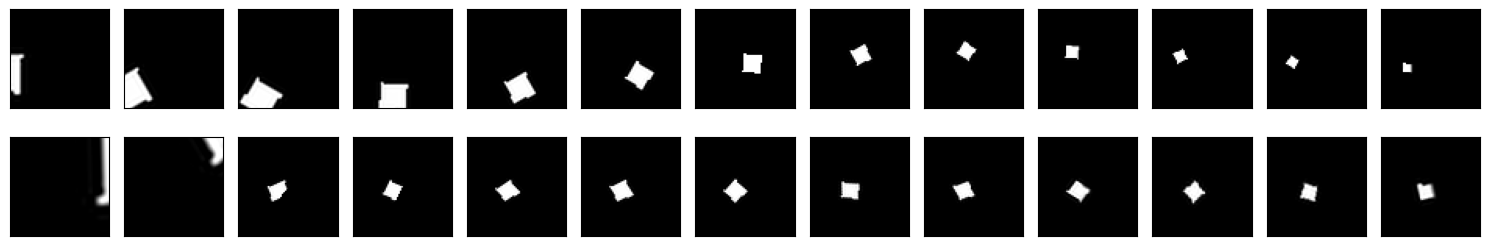

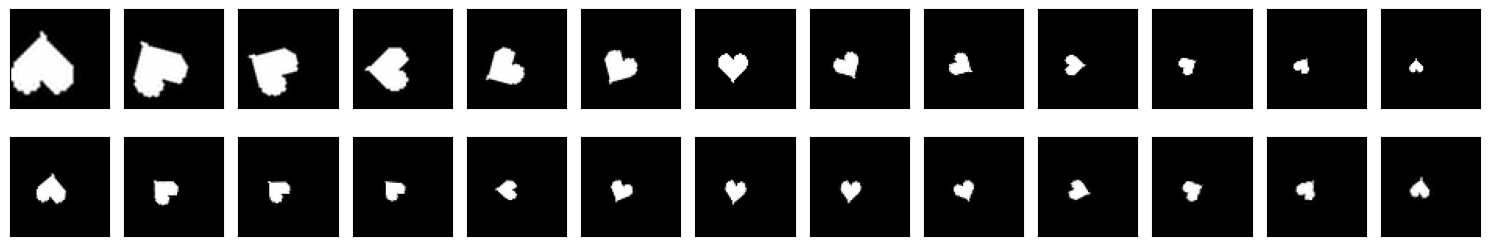

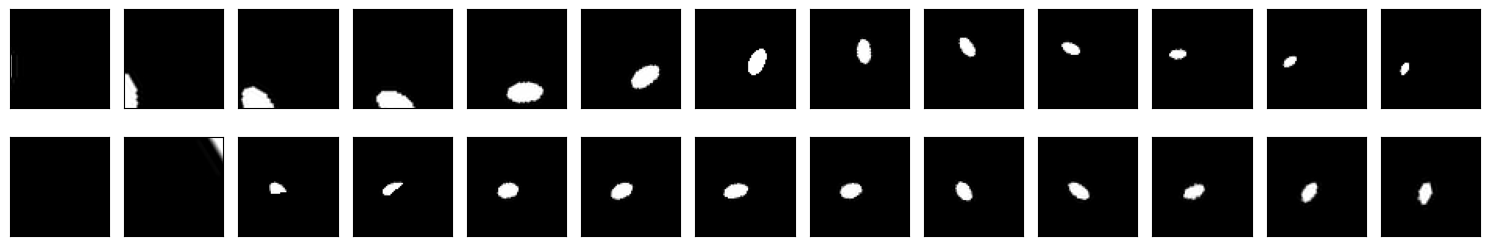

In [13]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    p_η = proto_model.apply({"params": proto_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    
    transform = proto_model.transform(η).inverse()
    xhat = transform.apply(x, **proto_config.get("transform_kwargs", {}))
    return xhat, η

transform_image = lambda x, η: proto_model.transform(η).apply(
    x, **(proto_config.get("transform_kwargs", None) or {})
)

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][15],
    val_batch['image'][0][12],
]:
    for mask in [
        # jnp.array([0, 0, 1, 0, 0]),
        # jnp.array([0, 1, 0, 0, 0]),
        # jnp.array([1, 1, 0, 0, 0]),
        # jnp.array([0, 0, 0, 1, 1]),
        jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
            x_,
            jnp.linspace(-jnp.array(proto_config.augment_bounds[:5]) * mask, jnp.array(proto_config.augment_bounds[:5]) * mask, 13)
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

# Generative Network

In [ ]:
gen_config = get_gen_config(f"aug_dsprites_v2,0")
gen_config.model.squash_to_bounds = True

In [ ]:
print((3 * gen_config.model.num_bins + 1) * len(gen_config.augment_bounds), gen_config.model.conditioner.hidden_dims[-1])
# Note, we probably want the first number to be smaller than the second number. Haven't tested this yet.

95 256


In [ ]:
train_ds, val_ds, _ = get_data(gen_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

In [ ]:
def prototype_function(x, rng):
    η = proto_model.apply({"params": proto_final_state.params}, x, train=False).sample(seed=rng)
    return η

In [ ]:
gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.to_dict()
)

gen_state = create_transformation_generative_state(gen_model, gen_config, gen_init_rng, input_shape)

INFO:absl:
+----------------------------------------------+--------------+-----------+-----------+--------+
| Name                                         | Shape        | Size      | Mean      | Std    |
+----------------------------------------------+--------------+-----------+-----------+--------+
| params/Conditioner_0/Dense_0/bias            | (95,)        | 95        | 0.0       | 0.0    |
| params/Conditioner_0/Dense_0/kernel          | (256, 95)    | 24,320    | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/bias      | (256,)       | 256       | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/kernel    | (261, 256)   | 66,816    | 0.000552  | 0.0619 |
| params/Conditioner_0/MLP_0/LayerNorm_0/bias  | (256,)       | 256       | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/LayerNorm_0/scale | (256,)       | 256       | 1.0       | 0.0    |
| params/Conditioner_1/Dense_0/bias            | (95,)        | 95        | 0.0       | 0.0    |
| params/Conditione

In [ ]:
train_step, eval_step = make_transformation_generative_train_and_eval(gen_model, gen_config, prototype_function=prototype_function)

In [ ]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=gen_config.to_dict(),
    mode="disabled",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [ ]:
total_steps = 10_000 # gen_config.steps
gen_final_state, history, _ = ciclo.train_loop(
    gen_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * gen_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

 2767/10000 [=======>......................] - ETA: 4:40 - log_p_η_x_hat: 6.2608 - loss: -5.5766 - mae: 0.6843 - log_p_η_x_hat_test: 7.0219 - loss_test: -6.6151 - mae_test: 0.4069  - ETA: 8:59 - log_p_η_x_hat: 5.2743 - loss: -4.6413 - mae: 0.6330 - log_p - ETA: 6:45 - log_p_η_x_hat: 5.9195 - loss: -5.2528 - mae: 0.6667 - log_p_η_x_hat_test: 6.2469 - loss_test: -5.7606 - mae_test: 0 - ETA: 6:43 - log_p_η_x_hat: 5.9357 - lo - ETA - ETA: 5:30 - log_p_η_x_hat: 6.2847 - loss: -5.6453 - mae: 0.6394 - log_p_η_x_hat_test: 6.2720 - loss_te - ETA: 5:21 - log_p_η_x_hat: 6.4345 - loss: -5.7672 - mae: 0.6674 - log_p_η_x_hat_test: 6.2720 - loss_te - ETA: 5:15 - log_p_η_x_hat: 6.5234 - loss: -5.8502 - mae: 0.6732 - log_p_η_x_hat_test: 6.8346 - loss_test: -6.3777 - mae_test: 0.4 - ETA: 5:14 - log_p_η_x_hat: 6.5307 - loss: -5 - ETA: 4:56 - log_p_η_x_hat: 6.4180 - loss: -5.7303 - mae: 0.6877 - log_p_η_x_hat_test: 7.0541 - loss_test: -6.6075 - mae_test: 0.446 - ETA: 4:56 - log_p_η_x_hat: 6.3994 - loss: -

10000/10000 [==============================] - 315s 32ms/step - log_p_η_x_hat: 8.4494 - loss: -7.8470 - mae: 0.6024 - log_p_η_x_hat_test: 8.8334 - loss_test: -8.4804 - mae_test: 0.3530: 3:34 - log_p_η_x_hat: 7.0036 - loss: -6.3459 - mae: 0.6576 - log_p_η_x_hat_test: 7.2465 -  - ETA: 3:30 - log_p_η_x_hat: 7.2137 - loss: -6.5695 - mae: 0.6442 - log_p_η_x_hat_test: 7.0368 - loss_test: -6.6727 - mae_test: 0.364 - ETA: 3:29 - log_p_η_x_hat: - ETA: 3:16 - log_p_η_x_hat: 7.3505 - loss: -6.6943 - mae: 0.6562 - log_p_η_x_hat_test: 7.2568 - loss_test: -6.8400 - mae_test: 0.4 - ETA: 3:16 - log_p_η_x_hat: 7.3548 - loss: -6.7002 - mae: 0.6547 - log_p_η_x_hat_test: 7.2568 - loss_test: -6.8400 - mae_test: 0.4 - ETA: 3:16 - log_p_η_x_hat: 7.3607 - loss: -6.7063 - mae: 0.654 - ETA: 3:07 - log_p_η_x_hat: 7.3630 - loss: -6.7038 - mae: 0.6592 - log_p_η_x_hat_test: 7.7864 - loss_test: -7.3959 - mae_test: 0.390 - ETA: 3:07 - log_p_η_x_hat: 7.3616 - loss: -6.7031 - mae: 0.6585 - log_p_η_x_hat_test: 7.7864 - 

In [ ]:
run.finish()

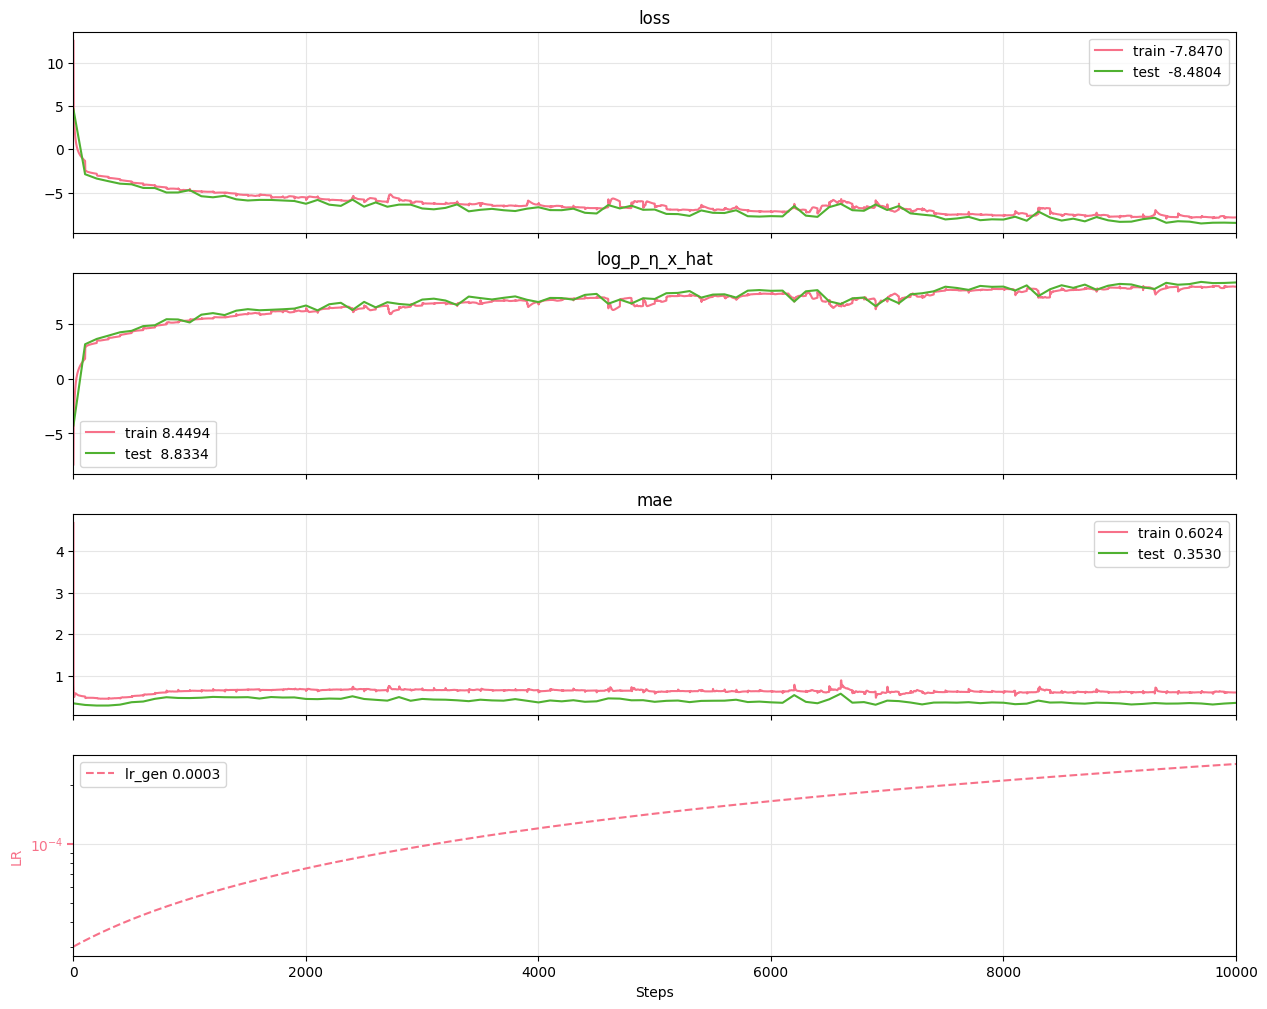

In [ ]:
fig = plot_gen_model_training_metrics(history)

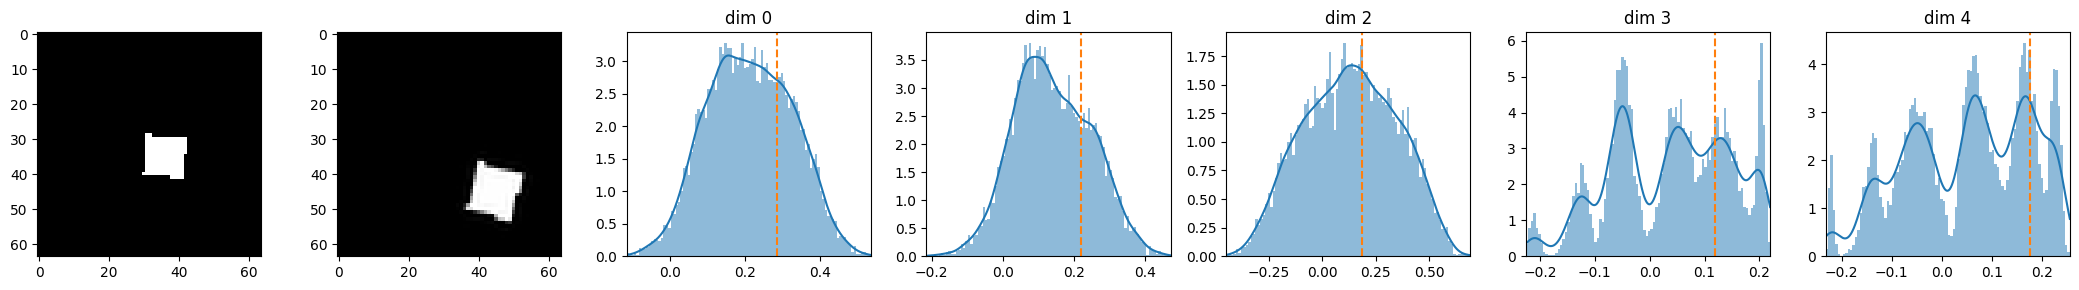

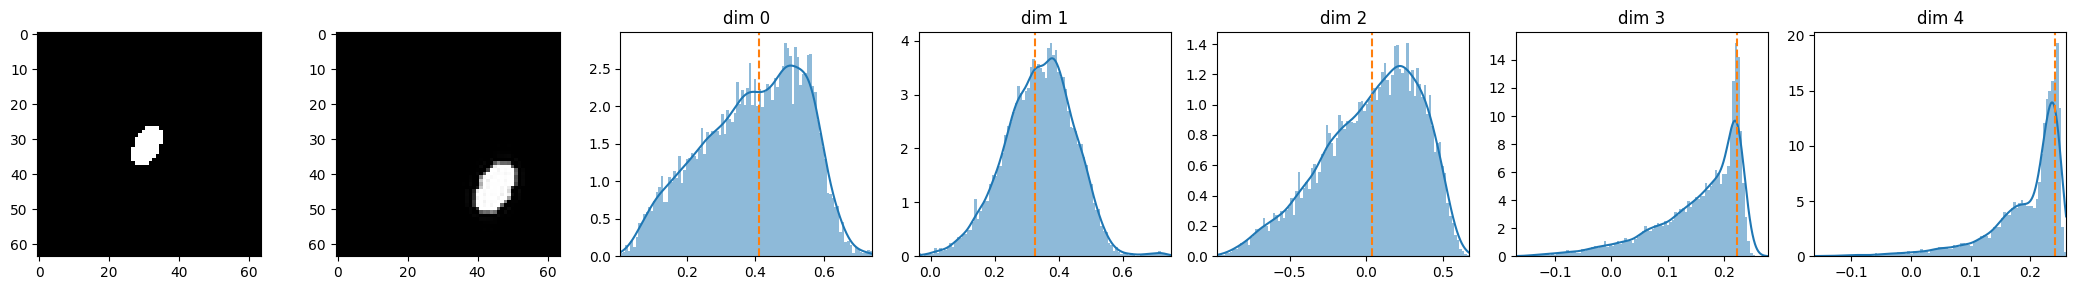

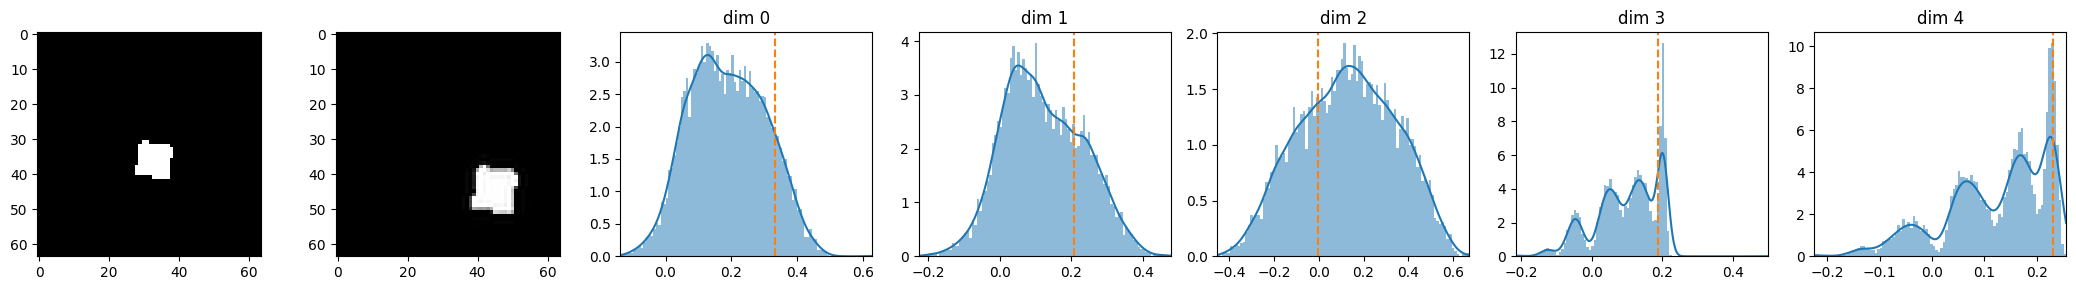

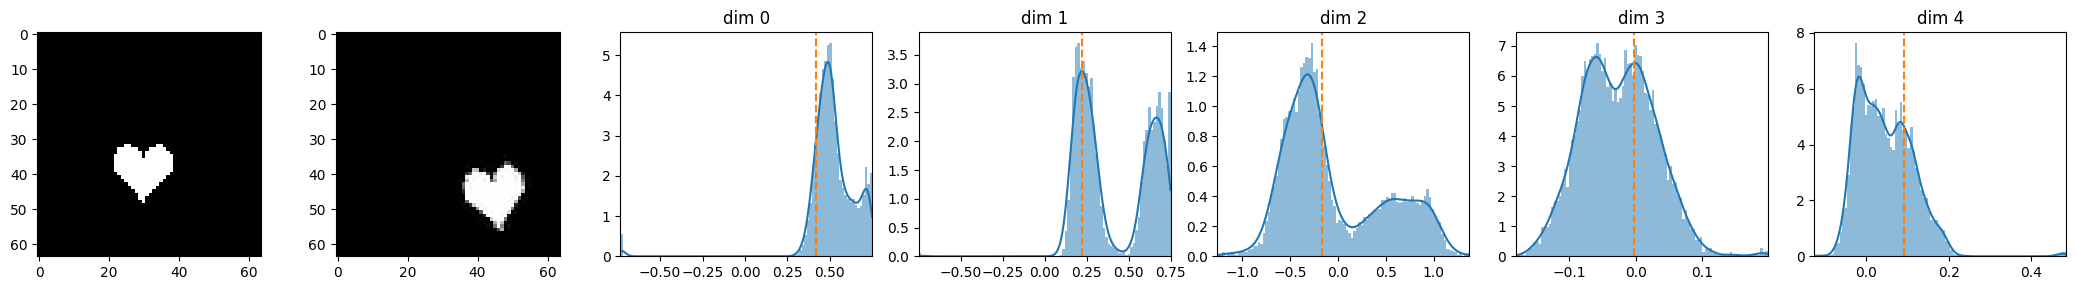

In [ ]:
for x in [
    val_batch["image"][0][14],
    val_batch["image"][0][1],
    val_batch["image"][0][4],
    val_batch["image"][0][9],
]:
    plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, gen_config)
    plt.show()
    plt.close(fig)

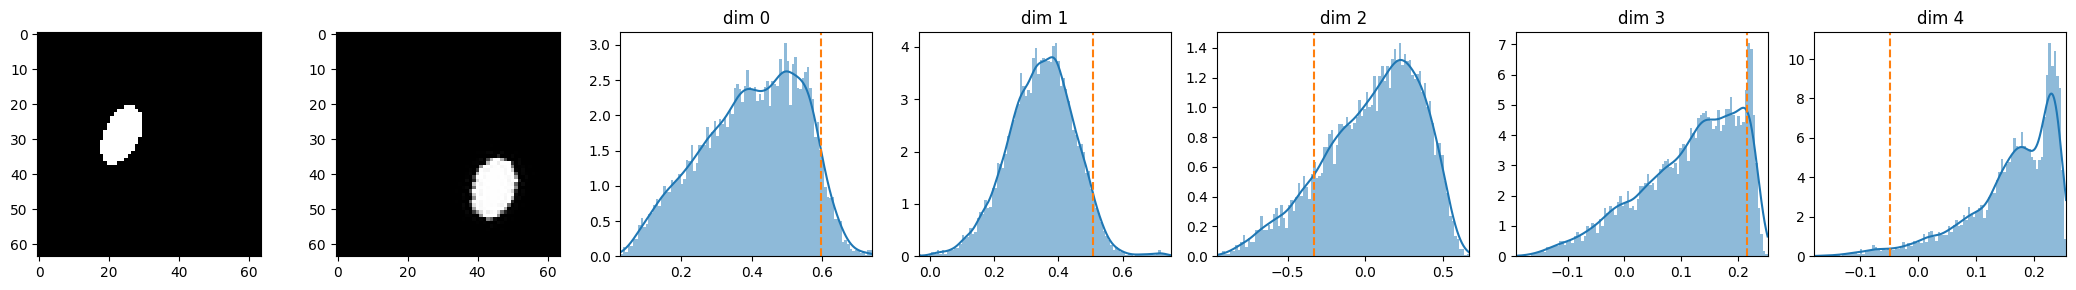

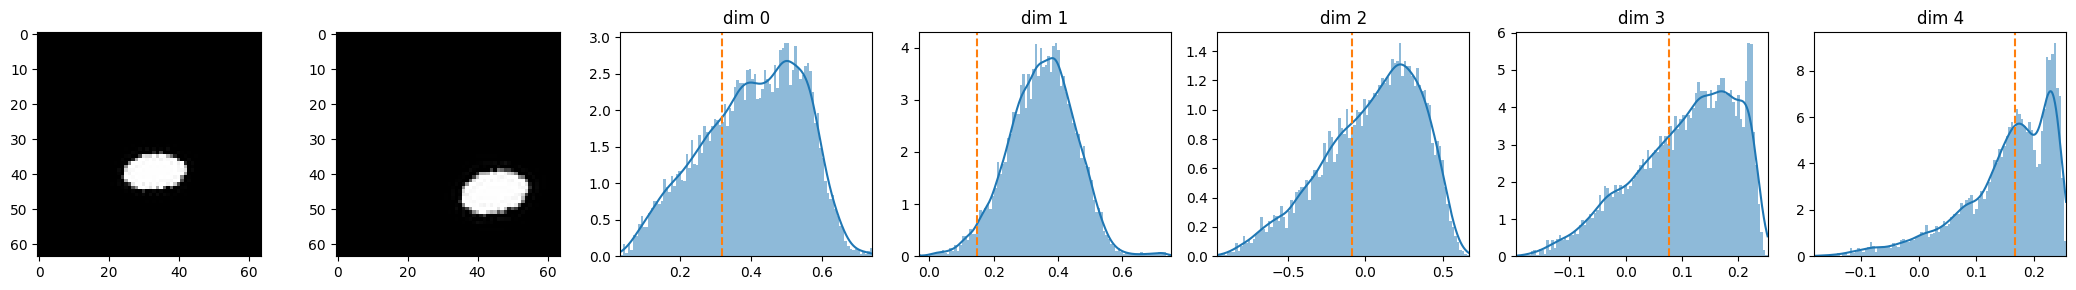

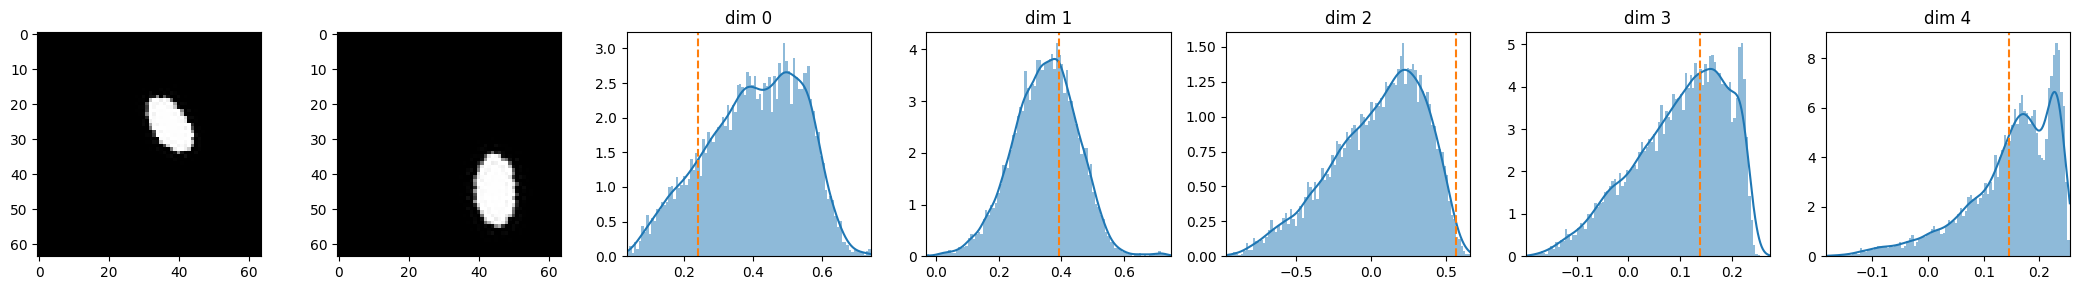

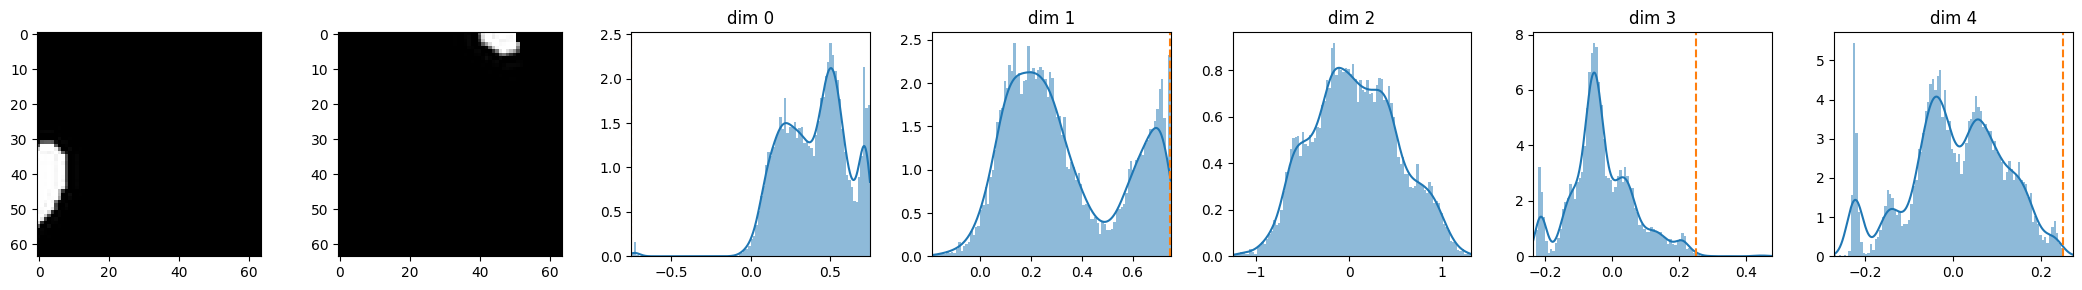

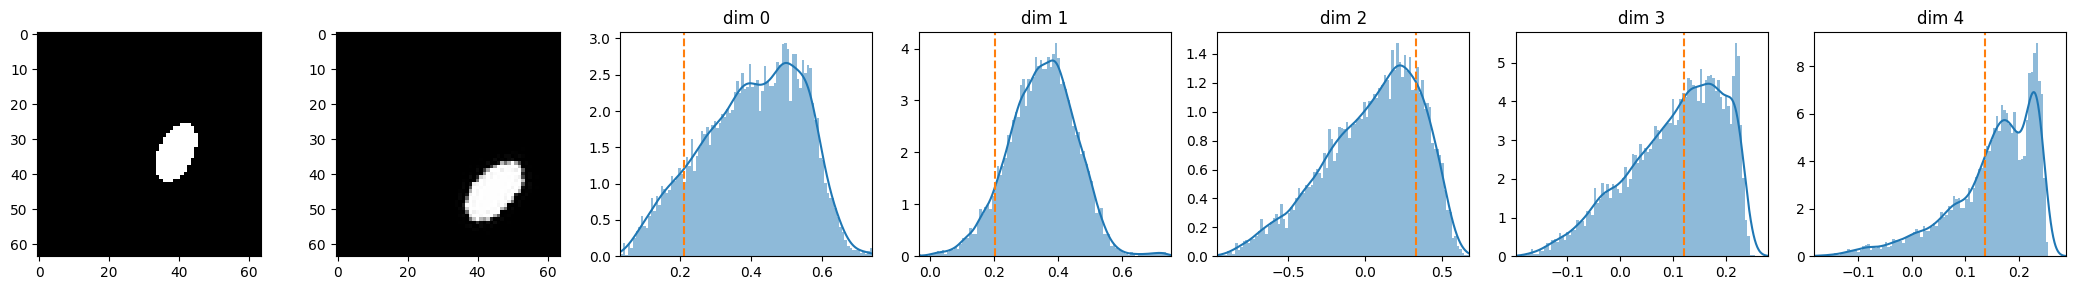

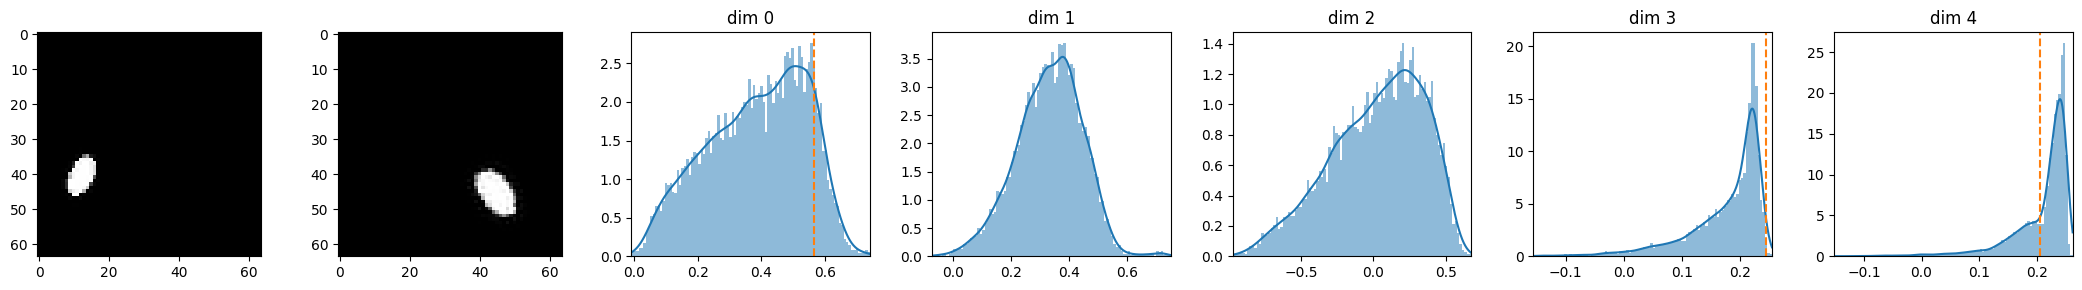

In [ ]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(gen_config.augment_bounds) * rot_mask, jnp.array(gen_config.augment_bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(gen_config.augment_bounds) * full_mask, jnp.array(gen_config.augment_bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, gen_config)

[]

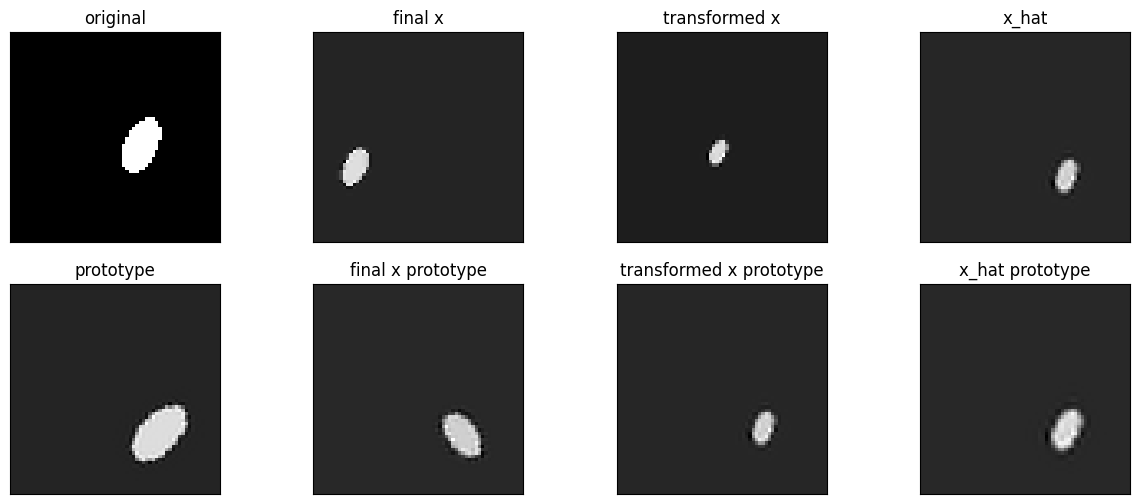

In [ ]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(gen_config.augment_bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
